<a href="https://colab.research.google.com/github/kimberly-di-knudtson/LandsatPop/blob/main/PopulationModelBuilding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SETuP

In [1]:
!pip install tensorflow_io

In [2]:
!pip install tensorflow_transform

In [3]:
!pip install realtimeplt

In [5]:
import numpy as np
import pandas as pd
import tensorflow_io as tfio
import tensorflow as tf
import tensorflow_transform as tft
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import metrics
from tensorflow.python.keras import optimizers
from PIL import Image
import matplotlib.pyplot as plt

In [6]:
tf.__version__

'2.7.0'

In [7]:
tf.keras.__version__

'2.7.0'

In [8]:
tfio.__version__

'0.22.0'

In [9]:
tft.__version__

'1.5.0'

In [10]:
from google.colab import auth
auth.authenticate_user()

In [11]:
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=MAs97DvN_6Xq5w-R7omq-8OjSrCpyp_7sTOLz_snUKw&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWgeHqgHsM5ALY5Nvr9MAXYZ5O9qbHwTCqpuvwZ6OzIIL4z4pCZrp_0

Successfully saved authorization token.


In [12]:
from google.colab import drive
root_dir = '/content/gdrive/MyDrive/Colab Notebooks/'
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [13]:
from google.cloud import storage

storage_client = storage.Client.from_service_account_json("/content/gdrive/MyDrive/Colab Notebooks/teak-banner-326719-d3c2870ab6ff.json")
# Make an authenticated API request
buckets = list(storage_client.list_buckets())
print(buckets)

[<Bucket: assign8bigdata>, <Bucket: landsat_conus_tiles>]


## vars, constants

In [14]:
BUCKET='landsat_conus_tiles'

In [15]:
TRAINING_DIR_BASE = "gs://"+BUCKET+"/"+'Training/' #1024 TFRecords per band_set, 30m resolution, 32 examples each

In [ ]:
TESTING_DIR_BASE = "gs://"+BUCKET+"/"+'Test/'

In [16]:
lsat_bands={}
lsat_bands['rgb']= ['B4', 'B3', 'B2'] #R,G,B respectively
lsat_bands['cir'] = ['B5', 'B4', 'B3'] #Color Infrared
lsat_bands['urban'] = ['B7', 'B6', 'B4'] #"Putting LSAT Bands to Work" blog
lsat_bands['ir'] = ['B11', 'B10', 'B7']
lsat_bands['reds'] = ['B11', 'B7', 'B4']
BAND_SETS = ['urban', 'ir', 'cir', 'reds', 'rgb']
RESOLUTIONS = ['1km', '30m']

KERNEL_SIZE = 224
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]


##TPU

In [17]:
tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(tpu_resolver)
tf.tpu.experimental.initialize_tpu_system(tpu_resolver)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.3.225.234:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.3.225.234:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


In [18]:
tpu_strategy = tf.distribute.TPUStrategy(tpu_resolver)
AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = tpu_strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS: 8


## Unet model from example...
This model is directly from the example on Google Earth Engine: https://colab.research.google.com/github/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb#scrollTo=M3WDAa-RUpXP

I have tried to modify this example for this project.


In [19]:
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import metrics
from tensorflow.python.keras import optimizers

OPTIMIZER = 'SGD'
LOSS = 'MeanSquaredError'
METRICS = ['RootMeanSquaredError']


def conv_block(input_tensor, num_filters):
	encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
	encoder = layers.BatchNormalization()(encoder)
	encoder = layers.Activation('relu')(encoder)
	encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
	encoder = layers.BatchNormalization()(encoder)
	encoder = layers.Activation('relu')(encoder)
	return encoder

def encoder_block(input_tensor, num_filters):
	encoder = conv_block(input_tensor, num_filters)
	encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
	return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
	decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
	decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	return decoder

def get_model():
  
	inputs = layers.Input(shape=[None, None, 3]) # 256
	encoder0_pool, encoder0 = encoder_block(inputs, 32) # 128
	encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64) # 64
	encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128) # 32
	encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256) # 16
	encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512) # 8
	center = conv_block(encoder4_pool, 1024) # center
	decoder4 = decoder_block(center, encoder4, 512) # 16
	decoder3 = decoder_block(decoder4, encoder3, 256) # 32
	decoder2 = decoder_block(decoder3, encoder2, 128) # 64
	decoder1 = decoder_block(decoder2, encoder1, 64) # 128
	decoder0 = decoder_block(decoder1, encoder0, 32) # 256
	outputs = layers.Conv2D(1, (1, 1), activation='relu')(decoder0)

	model = models.Model(inputs=[inputs], outputs=[outputs])

	model.compile(
		optimizer=optimizers.get(OPTIMIZER), 
		loss=losses.get(LOSS),
		metrics=[metrics.get(metric) for metric in METRICS])

	return model

## TFRecords ---> Dataset

https://colab.research.google.com/github/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb#scrollTo=WWZ0UXCVMyJP

In [20]:
DEFAULT_BAND_SET='urban'
def getFeaturesDict(band_set=DEFAULT_BAND_SET):
  features = lsat_bands[band_set] + ['population_count']
  print(features)
  # Specify the size and shape of patches expected by the model.
  columns = [
    tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in features
  ] 
  features_dict = dict(zip(features, columns))
  
  return features_dict

In [21]:
def parse_training_tfrecord(example_proto):
  """The parsing function.
  Read a serialized example into the structure defined by FEATURES_DICT.
  Args:
    example_proto: a serialized Example.
  Returns:
    A dictionary of tensors, keyed by feature name.
  """
#My examples are 224x224x3 image arrays, 
#with 3 image bands and one population_count band (the output to predict)
  return tf.io.parse_single_example(example_proto, getFeaturesDict()) 

def parse_test_tfrecord(example_proto):
  """The parsing function.
  Read a serialized example into the structure defined by FEATURES_DICT.
  Args:
    example_proto: a serialized Example.
  Returns:
    A dictionary of tensors, keyed by feature name.
  """
#My examples are polygon images...
  ##WILL HAVE TO DO SOMETHING ELSE...
  return tf.io.parse_single_example(example_proto, features_dict) 

def preprocess_train(inputs):
  """Function to convert a dictionary of tensors to a tuple of (inputs, outputs).
  Turn the tensors returned by parse_tfrecord into a stack in HWC shape.
  Args:
    inputs: A dictionary of tensors, keyed by feature name.
  Returns:
    A tuple of (inputs, outputs).
  """
  inputsList=[]
  for key in getFeaturesDict().keys():
    if key == 'population_counts':
      inputsList.append = inputs.get(key)
    else:
      inputsList.append(tft.scale_to_0_1(inputs.get(key)))
  stacked = tf.stack(inputsList, axis=0)
  print(stacked)
  # Convert from CHW to HWC
  stacked = tf.transpose(stacked, [1, 2, 0])
  inputs=stacked[:,:,:3]
  outputs=stacked[:,:,3:]

  return inputs, outputs

def get_training_dataset(band_set=DEFAULT_BAND_SET, resolution='30m'):

  """Function to read, parse and format to tuple a set of input tfrecord files.
  Get all the files matching the pattern, parse and convert to tuple.
  Args:
    pattern: A file pattern to match in a Cloud Storage bucket.
  Returns:
    A tf.data.Dataset
  """
  print(TRAINING_DIR_BASE+ band_set + '*')
  glob = tf.io.gfile.glob(TRAINING_DIR_BASE+ band_set + '*')
  num_records = len(glob)
  split_ind = int(0.75 * num_records)
  print("Found Files: ",num_records)
  TRAIN_SIZE = split_ind
  EVAL_SIZE = num_records - split_ind
  print("Found Files: ",num_records)
  print("Train: ", TRAIN_SIZE)
  print("Test: ", EVAL_SIZE)
  TRAINING_FILENAMES, VALID_FILENAMES = glob[:split_ind], glob[split_ind:]
  train_dataset = tf.data.TFRecordDataset(TRAINING_FILENAMES, compression_type='GZIP')
  valid_dataset = tf.data.TFRecordDataset(VALID_FILENAMES, compression_type='GZIP')
  train_dataset = train_dataset.map(parse_training_tfrecord, num_parallel_calls=AUTO)
  train_dataset = train_dataset.map(preprocess_train, num_parallel_calls=AUTO)
  valid_dataset = valid_dataset.map(parse_training_tfrecord, num_parallel_calls=AUTO)
  valid_dataset = valid_dataset.map(preprocess_train, num_parallel_calls=AUTO)
  return train_dataset, valid_dataset

In [22]:
def setup_train_dataset(dataset):
  dataset = dataset.shuffle(512, reshuffle_each_iteration=True)
  dataset = dataset.batch(32, drop_remainder=True) # drop_remainder is important on TPU, batch size must be fixed
  dataset = dataset.prefetch(AUTO)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
  return dataset

In [23]:
def setup_validation_dataset(dataset):
    dataset = dataset.batch(32, drop_remainder=True) # 10000 items in eval dataset, all in one batch
    dataset = dataset.cache() 
    dataset.prefetch(AUTO)
    return dataset

In [24]:
EPOCHS = 30
from livelossplot import PlotLossesKeras
def runModelTrainingForBandSet(band_set=DEFAULT_BAND_SET, resolution='30m'):
  print(band_set, resolution)
  train_dataset, valid_dataset =get_training_dataset(band_set, resolution)
  train_dataset = setup_train_dataset(train_dataset)
  valid_dataset = setup_validation_dataset(valid_dataset)
  
  with tpu_strategy.scope():
    model=get_model()
  
  model.fit(
    x=train_dataset, 
    epochs=EPOCHS,  
    validation_data=valid_dataset,
    callbacks=[PlotLossesKeras()])
  
  score = model.evaluate(valid_dataset)
  return {'model': model, 'score':score }

don't have complete data for reds and none for rgb at 30 m resolution

In [ ]:
BAND_SETS

['urban', 'ir', 'cir', 'reds', 'rgb']

In [25]:
DEFAULT_BAND_SET

'urban'

Running approx 3 min per epoch

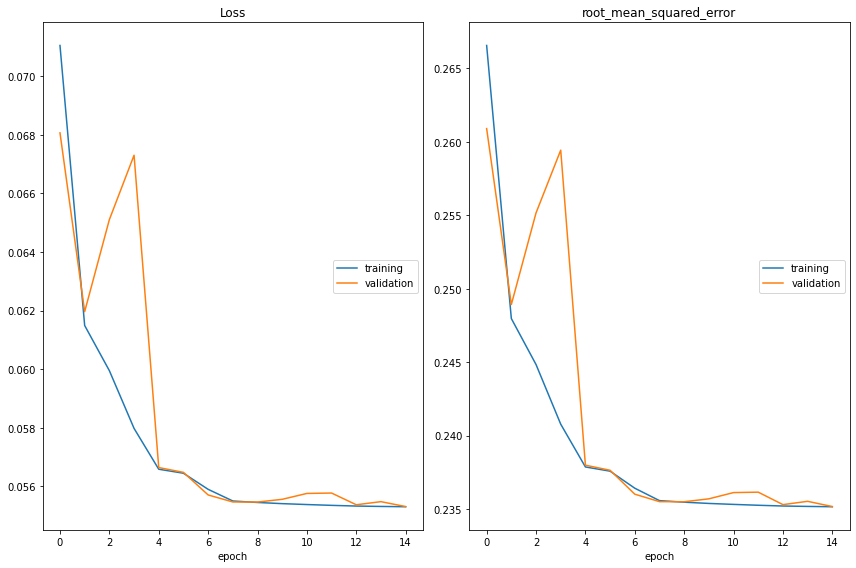

Loss
	training         	 (min:    0.055, max:    0.071, cur:    0.055)
	validation       	 (min:    0.055, max:    0.068, cur:    0.055)
root_mean_squared_error
	training         	 (min:    0.235, max:    0.267, cur:    0.235)
	validation       	 (min:    0.235, max:    0.261, cur:    0.235)
Epoch 16/30
304/504 [=================>............] - ETA: 1:12 - loss: 0.0553 - root_mean_squared_error: 0.2351

In [ ]:
from time import time
starttime=time()
out = runModelTrainingForBandSet('urban', '30m')
print("runtime: ",time()-starttime )

In [ ]:
all_models={}

In [ ]:
all_models['urban'] = out['model']
print('urban score: ',out['score'])

urban score:  [0.06856662034988403, 0.2618524134159088]


In [ ]:
DEFAULT_BAND_SET

'ir'

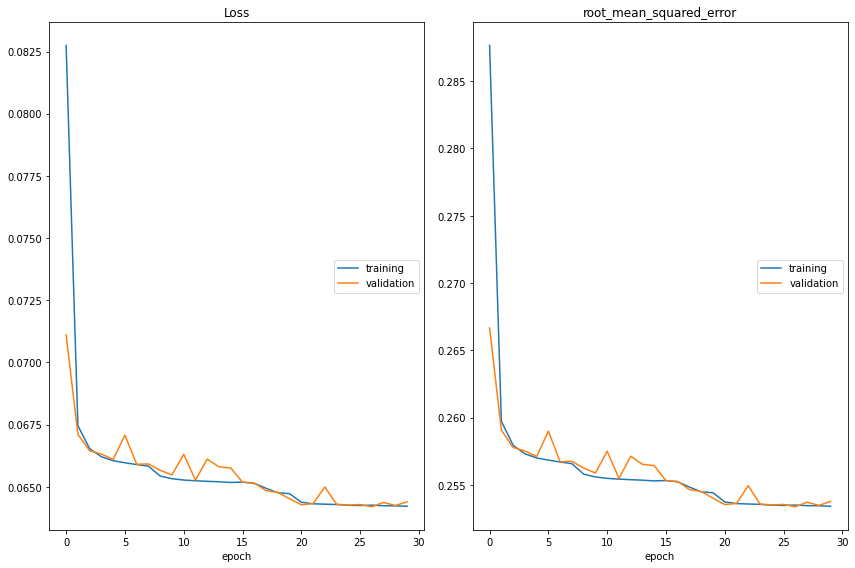

Loss
	training         	 (min:    0.064, max:    0.083, cur:    0.064)
	validation       	 (min:    0.064, max:    0.071, cur:    0.064)
root_mean_squared_error
	training         	 (min:    0.253, max:    0.288, cur:    0.253)
	validation       	 (min:    0.253, max:    0.267, cur:    0.254)
168/168 [==============================] - 6s 27ms/step - loss: 0.0644 - root_mean_squared_error: 0.2538
runtime:  5215.258728981018
ir score:  [0.06439778208732605, 0.253767192363739]


In [ ]:
starttime=time()
out = runModelTrainingForBandSet('ir', '30m')
print("runtime: ",time()-starttime )
all_models['ir'] = out['model']
print('ir score: ',out['score'])

In [ ]:
DEFAULT_BAND_SET

'cir'

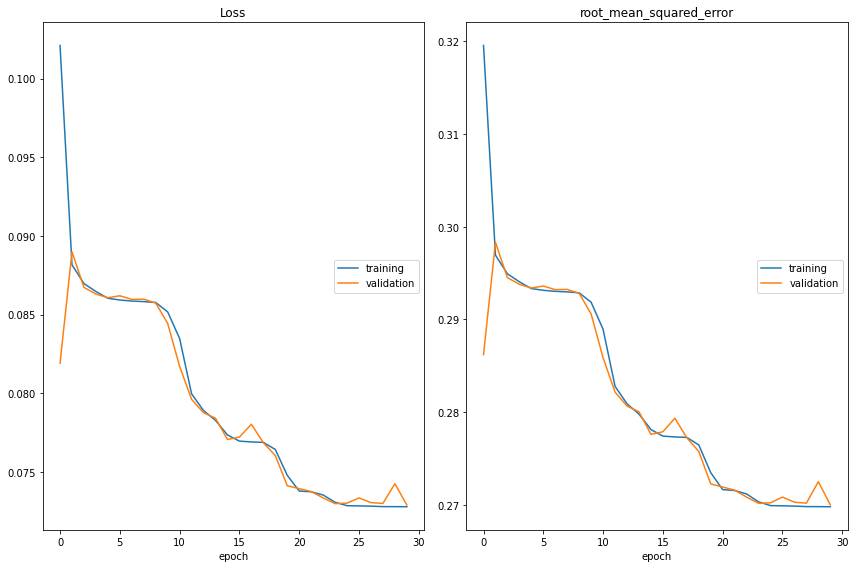

Loss
	training         	 (min:    0.073, max:    0.102, cur:    0.073)
	validation       	 (min:    0.073, max:    0.089, cur:    0.073)
root_mean_squared_error
	training         	 (min:    0.270, max:    0.320, cur:    0.270)
	validation       	 (min:    0.270, max:    0.298, cur:    0.270)
168/168 [==============================] - 6s 27ms/step - loss: 0.0729 - root_mean_squared_error: 0.2700
runtime:  5377.905844926834
cir score:  [0.07290276885032654, 0.27000513672828674]


In [ ]:
starttime=time()
out = runModelTrainingForBandSet('cir', '30m')
print("runtime: ",time()-starttime )
all_models['cir'] = out['model']
print('cir score: ',out['score'])

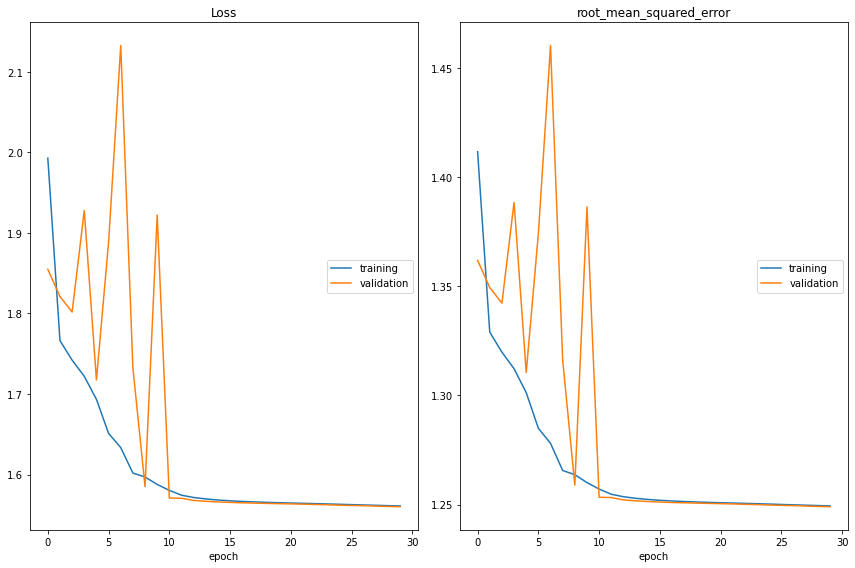

Loss
	training         	 (min:    1.561, max:    1.993, cur:    1.561)
	validation       	 (min:    1.560, max:    2.133, cur:    1.560)
root_mean_squared_error
	training         	 (min:    1.249, max:    1.412, cur:    1.249)
	validation       	 (min:    1.249, max:    1.460, cur:    1.249)


In [ ]:
runModelTrainingForBandSet(DEFAULT_BAND_SET, '30m')

In [ ]:
DEFAULT_BAND_SET

'cir'

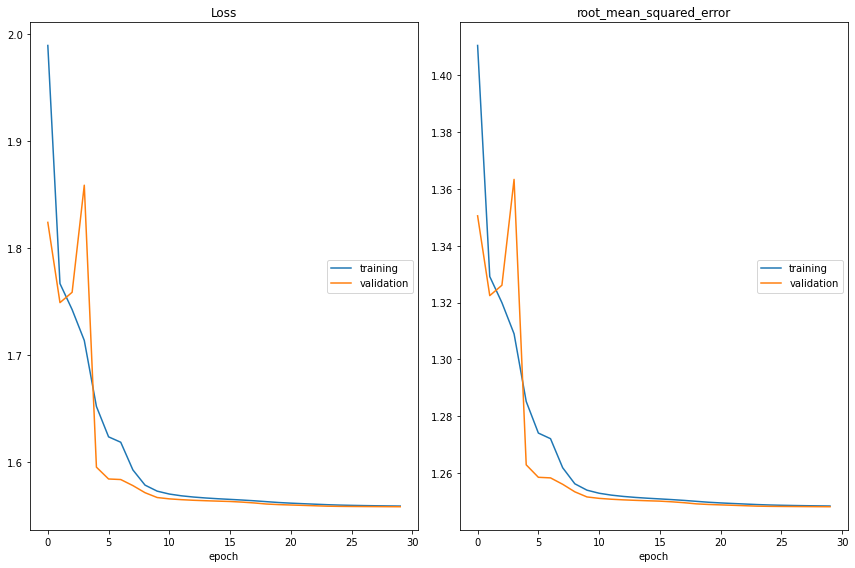

Loss
	training         	 (min:    1.559, max:    1.990, cur:    1.559)
	validation       	 (min:    1.558, max:    1.859, cur:    1.558)
root_mean_squared_error
	training         	 (min:    1.248, max:    1.411, cur:    1.248)
	validation       	 (min:    1.248, max:    1.363, cur:    1.248)


In [ ]:
runModelTrainingForBandSet(DEFAULT_BAND_SET, '30m')

In [ ]:
DEFAULT_BAND_SET

'reds'

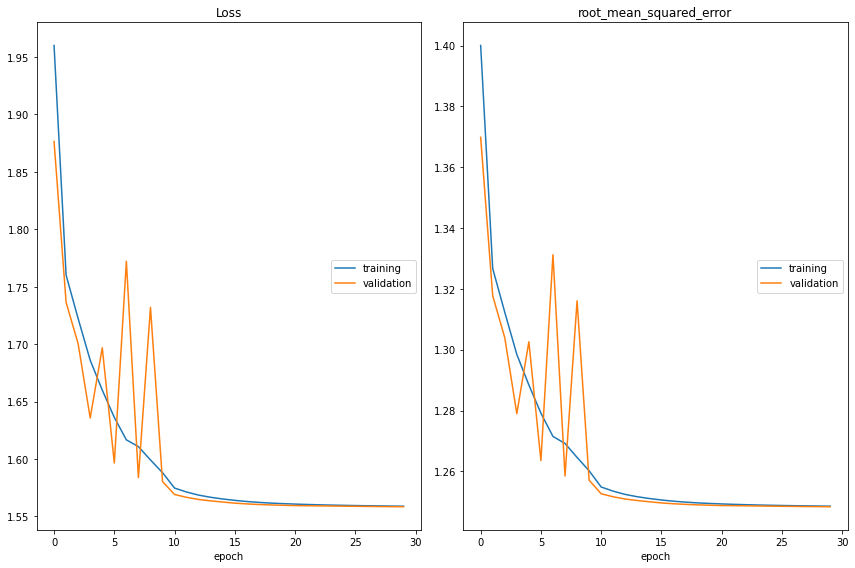

Loss
	training         	 (min:    1.559, max:    1.960, cur:    1.559)
	validation       	 (min:    1.558, max:    1.876, cur:    1.558)
root_mean_squared_error
	training         	 (min:    1.249, max:    1.400, cur:    1.249)
	validation       	 (min:    1.248, max:    1.370, cur:    1.248)


In [ ]:
runModelTrainingForBandSet(DEFAULT_BAND_SET, '30m')

In [ ]:
def doPrediction(band_set, pkey):
  """Perform inference on exported imagery, upload to Earth Engine.
  """
  kernel_buffer = [112,112]
  BANDS = lsat_bands[band_set]
  print('Looking for TFRecord files...')

  glob = tf.io.gfile.glob(TESTING_DIR_BASE+ band_set + pkey+'*')
  # Get the list of image files and the JSON mixer file.
  imageFilesList = []
  jsonFile = None
  for f in glob:
    if f.endswith('.tfrecord.gz'):
      imageFilesList.append(f)
    elif f.endswith('.json'):
      jsonFile = f

  # Make sure the files are in the right order.
  imageFilesList.sort()

  from pprint import pprint
  pprint(imageFilesList)
  print(jsonFile)

  import json
  # Load the contents of the mixer file to a JSON object.
  jsonText = !gsutil cat {jsonFile}
  # Get a single string w/ newlines from the IPython.utils.text.SList
  mixer = json.loads(jsonText.nlstr)
  pprint(mixer)
  patches = mixer['totalPatches']

  # Get set up for prediction.
  x_buffer = int(kernel_buffer[0] / 2)
  y_buffer = int(kernel_buffer[1] / 2)

  buffered_shape = [
      KERNEL_SHAPE[0] + kernel_buffer[0],
      KERNEL_SHAPE[1] + kernel_buffer[1]]

  imageColumns = [
    tf.io.FixedLenFeature(shape=buffered_shape, dtype=tf.float32) 
      for k in BANDS
  ]

  imageFeaturesDict = dict(zip(BANDS, imageColumns))

  def parse_image(example_proto):
    return tf.io.parse_single_example(example_proto, imageFeaturesDict)

  def toTupleImage(inputs):
    inputsList=[]
    for key in BANDS:
      inputsList.append(tft.scale_to_0_1(inputs.get(key)))
    stacked = tf.stack(inputsList, axis=0)
    stacked = tf.transpose(stacked, [1, 2, 0])
    return stacked

   # Create a dataset from the TFRecord file(s) in Cloud Storage.
  imageDataset = tf.data.TFRecordDataset(imageFilesList, compression_type='GZIP')
  imageDataset = imageDataset.map(parse_image, num_parallel_calls=AUTO)
  imageDataset = imageDataset.map(toTupleImage).batch(1)
  return imageDataset, patches

In [ ]:
imageDataset,patches = doPrediction('urban', '2015_22300')
predictions=all_models['urban'].predict(imageDataset, steps=patches, verbose=1)
print(predictions[0])

Looking for TFRecord files...
['gs://landsat_conus_tiles/Test/urban2015_22300.tfrecord.gz']
gs://landsat_conus_tiles/Test/urban2015_22300.json
{'patchDimensions': [224, 224],
 'patchesPerRow': 7,
 'projection': {'affine': {'doubleMatrix': [0.00026949458523585647,
                                            0.0,
                                            -83.88126763300127,
                                            0.0,
                                            -0.00026949458523585647,
                                            41.16799284062944]},
                'crs': 'EPSG:4326'},
 'totalPatches': 35}


ValueError: ignored

In [ ]:
# Perform inference.
  print('Running predictions...')
  predictions = m.predict(imageDataset, steps=patches, verbose=1)
  # print(predictions[0])

  for predictionPatch in predictions:
    print('Writing patch ' + str(patches) + '...')
    predictionPatch = predictionPatch[
        x_buffer:x_buffer+KERNEL_SIZE, y_buffer:y_buffer+KERNEL_SIZE]
    value=predictionPatch.flatten()
    print(value)
    sum_pop = sum(value)
    print (sum_pop)
    

In [ ]:
from tensorflow import keras
def getSequential():
  smodel = keras.Sequential(
    [
        #
        keras.Input(shape=(None,None,3)),
        keras.layers.Conv2D(224, (4,4), strides=(2,2), padding="same"),
        keras.layers.LeakyReLU(alpha=0.2),
     
        keras.layers.Conv2D(112, (4,4), strides=(2,2), padding="same"),
        keras.layers.LeakyReLU(alpha=0.2),
        
        keras.layers.Conv2D(56, (4,4), strides=(2,2), padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(alpha=0.2),
        
        keras.layers.Conv2D(28, (4,4), strides=(2,2), padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(alpha=0.2),
     
        keras.layers.Conv2D(14, (4,4), strides=(2,2), padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(alpha=0.2),
     
        keras.layers.Dropout(0.2),
        #linear regression part...
        keras.layers.Dense(1, activation="linear"),
    ],
  )
  smodel.compile(
      optimizer='Adam', 
	    loss=losses.get(LOSS),
	    metrics=[metrics.get(metric) for metric in METRICS])
  
  return smodel

In [ ]:
def getResNet():
  resnet = tf.keras.applications.ResNet50V2(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(224, 224, 3), #(with 'channels_last' data format) or (3, 224, 224) (with 'channels_first' data format
    pooling=None,
    classes=36815, #Max of population in sample (colorado right now)
    classifier_activation="softmax",
  )

  resnet.compile(
		optimizer='Adam', 
		loss=losses.get(LOSS),
		metrics=[metrics.get(metric) for metric in METRICS])
  
  return resnet

In [ ]:
EPOCHS = 10
from livelossplot import PlotLossesKeras
def runResNetModelTrainingForBandSet(band_set=DEFAULT_BAND_SET, resolution='30m'):
  print(band_set, resolution)
  train_dataset, valid_dataset =get_training_dataset(band_set, resolution)
  train_dataset = setup_train_dataset(train_dataset)
  valid_dataset = setup_validation_dataset(valid_dataset)
  
  with tpu_strategy.scope():
    model=getResNet()
  
  model.fit(
    x=train_dataset, 
    epochs=EPOCHS,  
    validation_data=valid_dataset,
    callbacks=[PlotLossesKeras()])
  
  score = model.evaluate(valid_dataset)
  return {'model': model, 'score':score }

In [ ]:
DEFAULT_BAND_SET

'urban'

In [ ]:
starttime=time()
out = runResNetModelTrainingForBandSet('urban', '30m')
print("runtime: ",time()-starttime )
all_models['urban_rn'] = out['model']
print('urban_RN score: ',out['score'])

urban 30m
gs://landsat_conus_tiles/Training/urban*
Found Files:  1024
Found Files:  1024
Train:  768
Test:  256
['B7', 'B6', 'B4', 'population_count']
['B7', 'B6', 'B4', 'population_count']
Tensor("stack:0", shape=(4, 224, 224), dtype=float32)
['B7', 'B6', 'B4', 'population_count']
['B7', 'B6', 'B4', 'population_count']
Tensor("stack:0", shape=(4, 224, 224), dtype=float32)
Epoch 1/10


ValueError: ignored

In [ ]:
EPOCHS = 10
from livelossplot import PlotLossesKeras
def runSeqModelTrainingForBandSet(band_set=DEFAULT_BAND_SET, resolution='30m'):
  print(band_set, resolution)
  train_dataset, valid_dataset =get_training_dataset(band_set, resolution)
  train_dataset = setup_train_dataset(train_dataset)
  valid_dataset = setup_validation_dataset(valid_dataset)
  
  with tpu_strategy.scope():
    model=getSequential()
  
  model.fit(
    x=train_dataset, 
    epochs=EPOCHS,  
    validation_data=valid_dataset,
    callbacks=[PlotLossesKeras()])
  
  score = model.evaluate(valid_dataset)
  return {'model': model, 'score':score }

In [ ]:
starttime=time()
out = runSeqModelTrainingForBandSet('urban', '30m')
print("runtime: ",time()-starttime )
all_models['urban_seq'] = out['model']
print('urban_seq score: ',out['score'])

urban 30m
gs://landsat_conus_tiles/Training/urban*
Found Files:  1024
Found Files:  1024
Train:  768
Test:  256
['B7', 'B6', 'B4', 'population_count']
['B7', 'B6', 'B4', 'population_count']
Tensor("stack:0", shape=(4, 224, 224), dtype=float32)
['B7', 'B6', 'B4', 'population_count']
['B7', 'B6', 'B4', 'population_count']
Tensor("stack:0", shape=(4, 224, 224), dtype=float32)
Epoch 1/10


ValueError: ignored